In [1]:
import pandas as pd
import numpy as np
import torch
import os
from PIL import Image
from io import BytesIO
import random
from zipfile import ZipFile

from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn.utils import shuffle
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

from DepthData_mob import DepthDataset
from DepthData_mob import Augmentation
from DepthData_mob import ToTensor

In [2]:
cd C:\\Users\\datta\\Desktop\\intern

C:\Users\datta\Desktop\intern


In [3]:
import os
import tensorflow as tf

#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


In [4]:
#from zipfile import ZipFile
#zf = ZipFile('Depth_estimation_mobilev2/data.zip', 'r')
#zf.extractall('/Depth_estimation_mobilev2/extract')
#zf.close()

In [4]:
# traincsv = shuffle(traincsv, random_state=0)
traincsv=pd.read_csv('C:/Users/datta/Desktop/intern/workspace/data/nyu2_train.csv')
traincsv = traincsv.values.tolist()
traincsv = shuffle(traincsv, random_state=2)

0 (640, 480) (640, 480)
1 (640, 480) (640, 480)


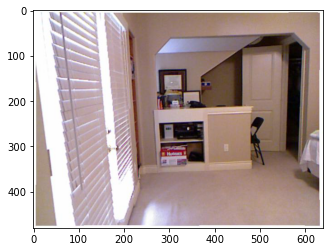

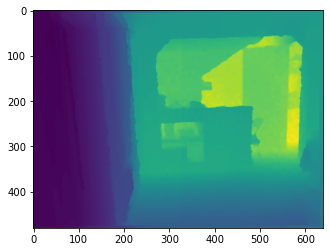

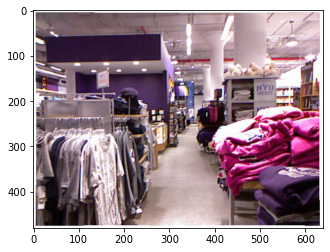

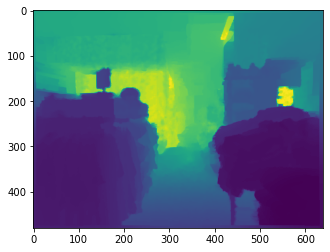

<Figure size 432x288 with 0 Axes>

In [6]:
#display a sample set of image and depth image
depth_dataset = DepthDataset(traincsv=traincsv,root_dir='C:/Users/datta/Desktop/intern/workspace/')
fig = plt.figure()
len(depth_dataset)
for i in range(len(depth_dataset)):
    sample = depth_dataset[i]
    print(i, sample['image'].size, sample['depth'].size)
    plt.imshow(sample['image'])
    plt.figure()
    plt.imshow(sample['depth'])
    plt.figure()
    if i == 1:
        plt.show()
        break

In [7]:
#testing code for trainloader

# depth_dataset = DepthDataset(traincsv=traincsv, root_dir='/workspace/',
#                 transform=transforms.Compose([Augmentation(0.5),ToTensor()]))
# batch_size=4
# train_loader=torch.utils.data.DataLoader(depth_dataset, batch_size, shuffle=True)
# dataiter = iter(train_loader)
# images, labels = dataiter.next()

In [5]:
#loading the mobilNetDepth model
from Mobile_model import Model

In [6]:
import cv2
import kornia 

def ssim(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):
    ssim = kornia.losses.SSIM(window_size=11,max_val=val_range,reduction='none')
    return ssim(img1, img2)

In [7]:
import matplotlib
import matplotlib.cm
import numpy as np


def DepthNorm(depth, maxDepth=1000.0): 
    return maxDepth / depth

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def colorize(value, vmin=10, vmax=1000, cmap='plasma'):
    value = value.cpu().numpy()[0,:,:]

    # normalize
    vmin = value.min() if vmin is None else vmin
    vmax = value.max() if vmax is None else vmax
    if vmin!=vmax:
        value = (value - vmin) / (vmax - vmin) # vmin..vmax
    else:
        # Avoid 0-division
        value = value*0.
    # squeeze last dim if it exists
    #value = value.squeeze(axis=0)

    cmapper = matplotlib.cm.get_cmap(cmap)
    value = cmapper(value,bytes=True) # (nxmx4)

    img = value[:,:,:3]

    return img.transpose((2,0,1))

In [8]:
def LogProgress(model, writer, test_loader, epoch):
    model.eval()
    sequential = test_loader
    sample_batched = next(iter(sequential))
    #image = torch.autograd.Variable(sample_batched['image'].cuda())
    #depth = torch.autograd.Variable(sample_batched['depth'].cuda(non_blocking=True))
    image = torch.autograd.Variable(sample_batched['image'])
    depth = torch.autograd.Variable(sample_batched['depth'])
    
    if epoch == 0: writer.add_image('Train.1.Image', vutils.make_grid(image.data, nrow=6, normalize=True), epoch)
    if epoch == 0: writer.add_image('Train.2.Depth', colorize(vutils.make_grid(depth.data, nrow=6, normalize=False)), epoch)
    output = DepthNorm( model(image) )
    writer.add_image('Train.3.Ours', colorize(vutils.make_grid(output.data, nrow=6, normalize=False)), epoch)
    writer.add_image('Train.3.Diff', colorize(vutils.make_grid(torch.abs(output-depth).data, nrow=6, normalize=False)), epoch)
    del image
    del depth
    del output
    

In [8]:
import time
import argparse
import datetime

import torch
import torch.nn as nn
import torch.nn.utils as utils
import torchvision.utils as vutils    
from tensorboardX import SummaryWriter

In [6]:
traincsv=pd.read_csv('C:/Users/datta/Desktop/intern/workspace/data/nyu2_test.csv',header=None)
traincsv = traincsv.values.tolist()
#traincsv = shuffle(traincsv, random_state=2)

In [9]:
#Evaluations

#model = Model().cuda()
model = Model()
model = nn.DataParallel(model)
#load the model if needed
model.load_state_dict(torch.load(r'C:\Users\datta\Desktop\intern\workspace\6.pth',map_location=torch.device('cpu')))
model.eval()
batch_size=1

depth_dataset = DepthDataset(traincsv=traincsv, root_dir=r'C:\Users\datta\Desktop\intern\workspace',transform=transforms.Compose([ToTensor()]))
train_loader=DataLoader(depth_dataset, batch_size, shuffle=False)



    

In [10]:
depth_imgs=[]
trts=[]
count=0
print(len(train_loader))
for sample_batched1  in (train_loader):
    count=count+1
    #image1 = torch.autograd.Variable(sample_batched1['image'].cuda())
    image1 = torch.autograd.Variable(sample_batched1['image'])
    outtt=model(image1 )
    x=outtt.detach().cpu().numpy()
    for i in range(batch_size):
        x[i]=x[i].reshape(240,320)
        depth_imgs.append(x[i])
    break
    if count%50==0:
        print(count)

654


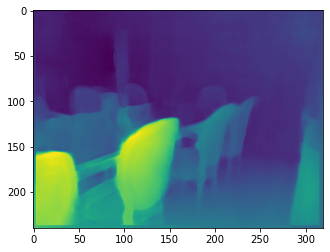

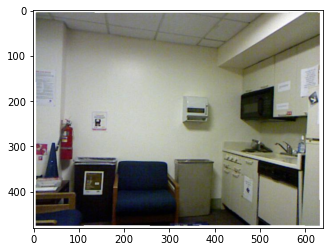

In [13]:
#ploting the evaluated images
x=outtt.detach().cpu().numpy()
x.shape
x=x.reshape(batch_size,240,320)
for i in range(batch_size):
    plt.imshow(x[i])
    plt.figure()
    plt.imshow(sample_batched1['image'].detach().cpu().numpy().reshape(3,480,640).transpose(1,2,0))

In [19]:
folder=r'C:\Users\datta\Desktop\intern\DenseDepth-master\DenseDepth-master\Tensorflow\data\nyu2_test'
images = []
count=-1
for filename in os.listdir(folder):
    count=count+1
    if(count%2!=0):
        img = cv2.imread(os.path.join(folder,filename),0)
        if img is not None:
            img=cv2.resize(img, (0, 0), fx = 0.5, fy = 0.5)
            images.append(img)

In [32]:
folder=r'C:\Users\datta\Desktop\intern\DenseDepth-master\DenseDepth-master\Tensorflow\data\nyu2_test'
rgb = []
count=-1
for filename in os.listdir(folder):
    count=count+1
    if(count%2==0):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img=cv2.resize(img, (0, 0), fx = 0.5, fy = 0.5)
            rgb.append(img)

In [20]:
gt=np.array(images)
pred=np.max(depth_imgs)-np.array(depth_imgs)

In [25]:
np.shape(gt)

(654, 240, 320)

In [26]:
np.shape(

(654, 1, 240, 320)

In [ ]:
thresh = np.maximum((gt / pred), (pred / gt))
a1 = (thresh < 1.25   ).mean()
a2 = (thresh < 1.25 ** 2).mean()
a3 = (thresh < 1.25 ** 3).mean()
abs_rel = np.mean(np.abs(gt - pred) / gt)
rmse = (gt - pred) ** 2
rmse = np.sqrt(rmse.mean())
log_10 = (np.abs(np.log10(gt)-np.log10(pred))).mean()

In [ ]:
print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}".format('a1', 'a2', 'a3', 'rel', 'rms','log_10'))
print("{:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}".format(a1,a2,a3,abs_rel,rmse,log_10))

In [ ]:
ind=2
print(np.shape(rgb[0]))
plt.imshow(gt[ind])
plt.figure()
plt.imshow(pred[ind])
cv2.imwrite('pred.png',pred[ind])
plt.figure()
plt.imshow(rgb[ind])
cv2.imwrite('rgb.png',rgb[ind])


In [69]:
d=pred[ind]
img=rgb[ind]

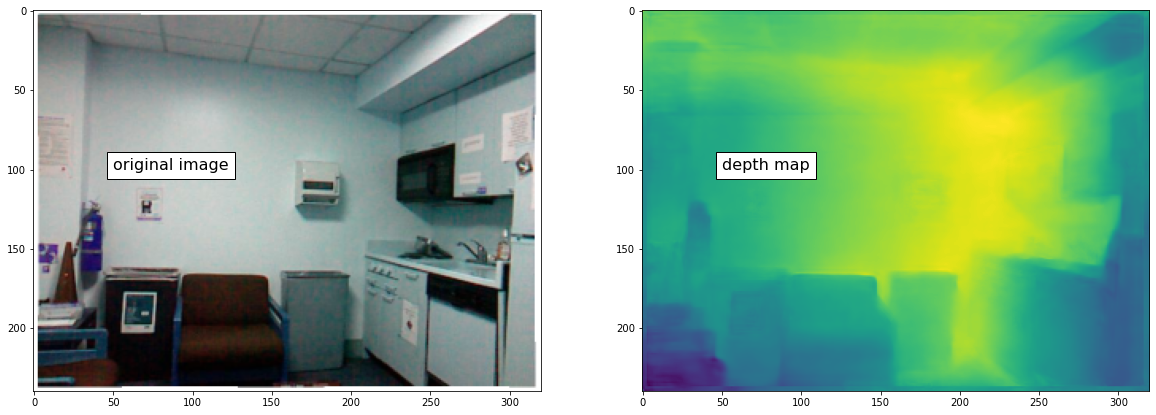

In [70]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].text(50, 100, 'original image', fontsize=16, bbox={'facecolor': 'white', 'pad': 6})
ax[0].imshow(img)

ax[1].text(50, 100, 'depth map', fontsize=16, bbox={'facecolor': 'white', 'pad': 6})
ax[1].imshow(d)

In [71]:
d = np.flipud(d)
img = np.flipud(img)

Wall time: 28.5 s


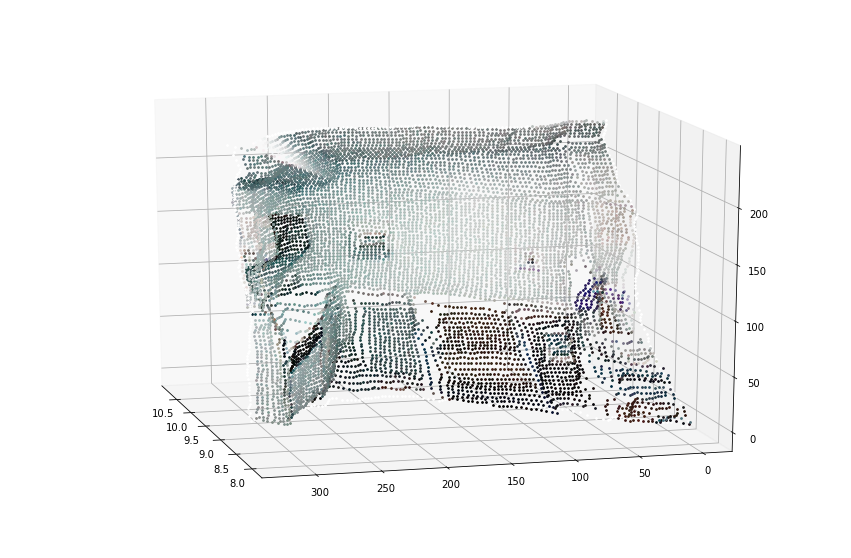

In [72]:
%%time
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')

STEP = 3
for x in range(0, img.shape[0], STEP):
    for y in range(0, img.shape[1], STEP):
        ax.scatter(
            d[x,y], y, x,
            c=[tuple(img[x, y, :3]/255)], s=3)      
    ax.view_init(15, 165)

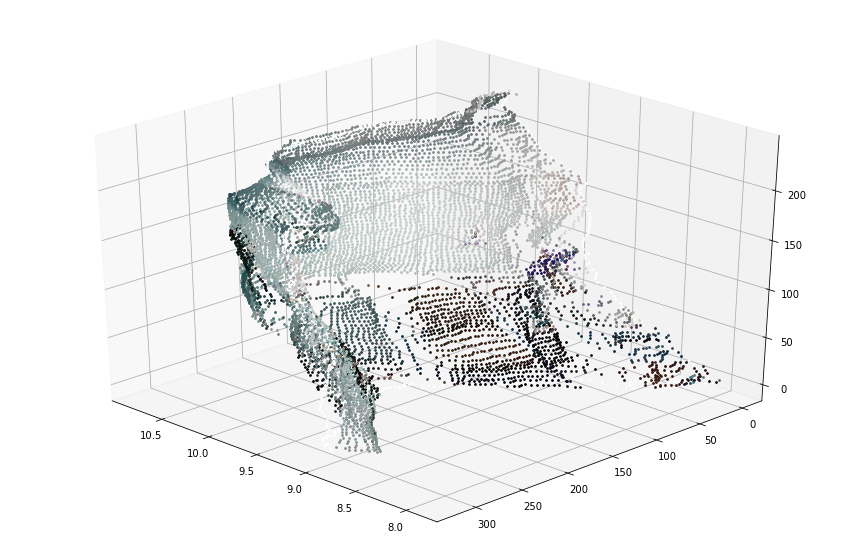

In [416]:
ax.view_init(30, 135)
fig

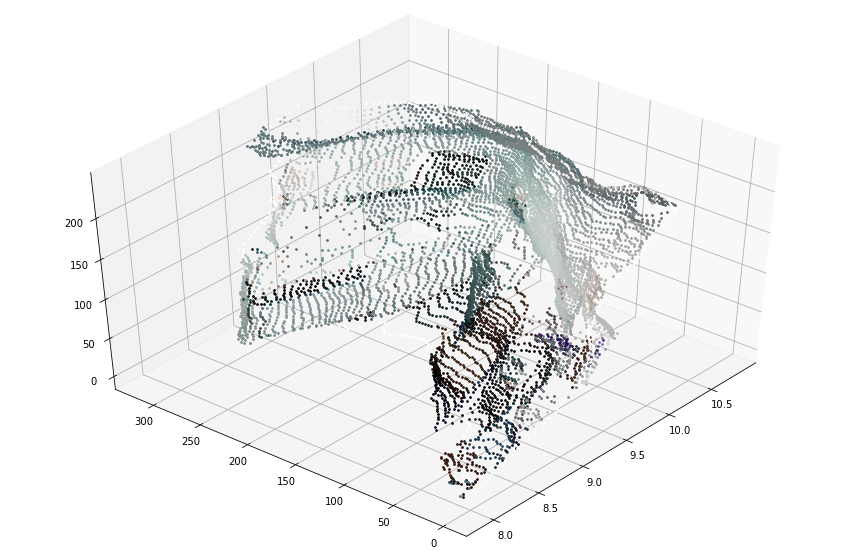

In [417]:
ax.view_init(45, 220)
fig

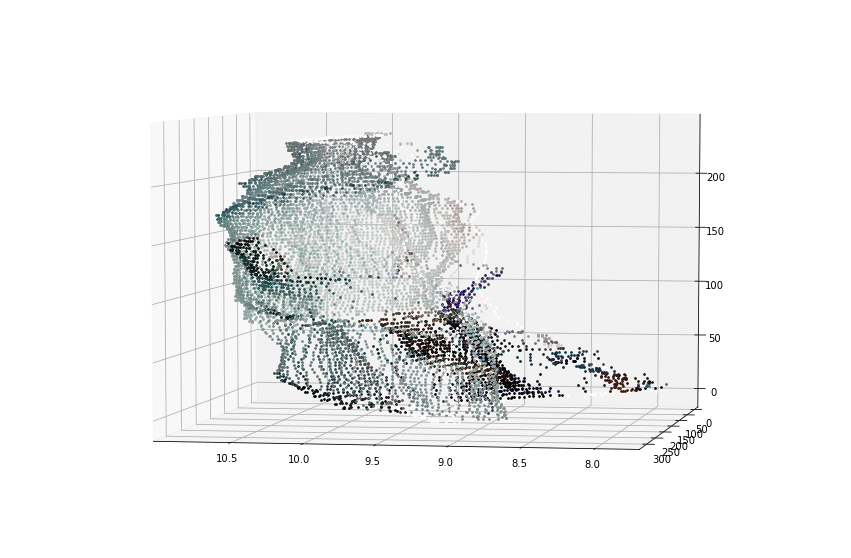

In [418]:
ax.view_init(5, 100)
fig